Key takeaway: dropping highly correlated features imporved model performance. This is the best model so far. 

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    brier_score_loss
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


In [149]:
def feature_engineering(df):

    # Create target variable
    df['default'] = (df.amount_outstanding_21d > 0).astype(int)

    # Ensure loan_issue_date is datetime 
    df['loan_issue_date'] = pd.to_datetime(df['loan_issue_date'], errors='coerce')

    # Combine year and month for card expiration
    df['card_expiry_date'] = pd.to_datetime(
        df.apply(
            lambda row: f"{int(row['card_expiry_year'])}-{int(row['card_expiry_month']):02d}-01"
            if pd.notna(row['card_expiry_year']) and pd.notna(row['card_expiry_month'])
            else np.nan,
            axis=1
        ), 
        errors='coerce'
    )

    # Calculate number months to card expiration date
    df['months_to_card_expiration'] = np.where(
        df['card_expiry_date'].notna() & df['loan_issue_date'].notna(),
        (df['card_expiry_date'].dt.year - df['loan_issue_date'].dt.year) * 12 +
        (df['card_expiry_date'].dt.month - df['loan_issue_date'].dt.month),
        np.nan
    )

    # Convert month_to_card_expiration to integer
    df['months_to_card_expiration'] = df['months_to_card_expiration'].fillna(-1).astype(int).replace(-1, np.nan)

    # Create a missingness flag for existing_klarna_debt
    df['existing_debt_missing'] = df['existing_klarna_debt'].isnull().astype(int)

    # Replace missing values for existing_klarna_debt with 0
    df['existing_klarna_debt'] = df['existing_klarna_debt'].fillna(0)

    # Loan_to_debt_ratio
    df['loan_to_debt_ratio'] = df['loan_amount'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_7d_to_debt
    df['new_exposure_7d_to_debt'] = df['new_exposure_7d'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_14d_to_debt
    df['new_exposure_14d_to_debt'] = df['new_exposure_14d'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # Repayment to total debt
    df['repayment_1y_to_debt'] = (df['amount_repaid_1y'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_3m_to_debt'] = (df['amount_repaid_3m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_1m_to_debt'] = (df['amount_repaid_1m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_14d_to_debt'] = (df['amount_repaid_14d'] / (df['existing_klarna_debt'] + df['loan_amount']))


    epsilon = 1e-5  # Small constant

    # Ratio of confirmed payments to active loans
    df['num_conf_payments_6m_to_num_loans'] = df['num_confirmed_payments_6m'] / (df['num_active_loans'] + epsilon)

    # Merchant categories
    top_n_categories = ['General Shoes & Clothing', 'Youthful Shoes & Clothing',
                         'Adult Shoes & Clothing', 'Event - Broker & Agencies',
                         'Travel - Accommodation & Resorts']

    # Merchant groups
    top_n_groups = ['Clothing & Shoes', 'Intangible products', 'Leisure, Sport & Hobby',
                     'Jewelry & Accessories', 'Home & Garden']

    # Reassign categories outside the top n and 'Unknown' to 'Other'
    df['merchant_category'] = df['merchant_category'].apply(
        lambda x: 'Other' if x not in top_n_categories or x == 'Unknown' else x
    )

    # Reassign groups outside the top n and 'Unknown' to 'Other'
    df['merchant_group'] = df['merchant_group'].apply(
        lambda x: 'Other' if x not in top_n_groups or x == 'Unknown' else x
    )

    return df

# Load and split data

In [150]:
# Load the data
df = pd.read_csv('data/mlcasestudy.csv')

In [151]:
# Splitting the data into train, validation and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [152]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)


In [153]:
# Apply the processing functions to the data

# create target variable
df_train = feature_engineering(df_train)
df_val = feature_engineering(df_val)
df_test = feature_engineering(df_test)
df_full_train = feature_engineering(df_full_train)


Prepare feature list

In [154]:
# Define helper columns
helper_columns = ['amount_outstanding_14d', 'amount_outstanding_21d', 
                  'card_expiry_month', 'card_expiry_year','card_expiry_date', 'loan_id', 'loan_issue_date']

# Extract categorical and numerical columns
categorical_features_eda = df_train.select_dtypes(include='object').columns.difference(helper_columns).tolist()
numerical_features_eda = df_train.select_dtypes(exclude='object').columns.difference(helper_columns + ['default']).tolist()


# Print categorical features 
print("\nCategorical features to explore:\n")
print("\n".join(categorical_features_eda))

# Print numerical features 
print("\nNumerical features to explore:\n")
print("\n".join(numerical_features_eda))




Categorical features to explore:

merchant_category
merchant_group

Numerical features to explore:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
days_since_first_loan
existing_debt_missing
existing_klarna_debt
loan_amount
loan_to_debt_ratio
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt


Feature selection - identify highly correlated features and drop to avoid multicollinearity. 

In [155]:
# Compute the correlation matrix
corr_matrix = df_train[numerical_features_eda].corr()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [156]:

# Set the correlation threshold
threshold = 0.90

# Find index of features with correlation greater than the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f'There are {len(to_drop)} columns to remove:')
print(to_drop)

There are 3 columns to remove:
['amount_repaid_1m', 'amount_repaid_6m', 'num_confirmed_payments_6m']


Finalize list of features

In [157]:
# Remove from the list of features as needed
numerical_features = [
    feature for feature in numerical_features_eda 
    if feature not in to_drop 
    #and feature not in helper_columns
]

# Remove from the list of features as needed
categorical_features = categorical_features_eda 


# Print numerical features as a vertical list
print("\nNumerical features to use in training:\n")
print("\n".join(numerical_features))

# Print categorical features as a vertical list
print("\nCategorical features to use in training:\n")
print("\n".join(categorical_features))




Numerical features to use in training:

amount_repaid_14d
amount_repaid_1y
amount_repaid_3m
days_since_first_loan
existing_debt_missing
existing_klarna_debt
loan_amount
loan_to_debt_ratio
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt

Categorical features to use in training:

merchant_category
merchant_group


In [158]:

# Assert that 'default' is not in numerical_features
assert 'default' not in numerical_features, "'default' is still in numerical_features!"


In [159]:
# Get all columns in df_train
all_columns = set(df_train.columns)

# Combine numerical_features and categorical_features
selected_features = set(numerical_features + categorical_features)

# Find columns that are not in either list
not_in_training = all_columns - selected_features

# Print the result
print("\nColumns not included in training:\n")
print("\n".join(sorted(not_in_training)))




Columns not included in training:

amount_outstanding_14d
amount_outstanding_21d
amount_repaid_1m
amount_repaid_6m
card_expiry_date
card_expiry_month
card_expiry_year
default
loan_id
loan_issue_date
num_confirmed_payments_6m


# Preprocessing pipeline

Define the steps to prepare data for training and evaluation

In [160]:
# Create transformations for each type of features

# Numerical features - no processing
numerical_transformer = 'passthrough'

# Categorical features - one-hot encoding ignoring unknown categories
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [161]:
# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [162]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

Apply preprocessing

In [163]:
# Transform training data
X_train_transformed = preprocessing_pipeline.fit_transform(df_train[numerical_features + categorical_features])
y_train = df_train['default'].values

# Transform validation data
X_val_transformed = preprocessing_pipeline.transform(df_val[numerical_features + categorical_features])
y_val = df_val['default'].values

In [164]:
# Get feature names from the preprocessing pipeline
numerical_features_transformed = numerical_features 

categorical_features_transformed = preprocessing_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_features)

# Combine numerical and transformed categorical feature names
all_feature_names = list(numerical_features_transformed) + list(categorical_features_transformed)

## Assess calibration on the training data


In [165]:
final_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators = 100,
        eta = 0.2,
        max_depth = 2,
        min_child_weight = 5,
        subsample = 1.0,
        colsample_bytree = 1.0,
        gamma = 0)


In [166]:
final_model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [167]:
y_pred_val = final_model.predict_proba(X_val_transformed)[:, 1]

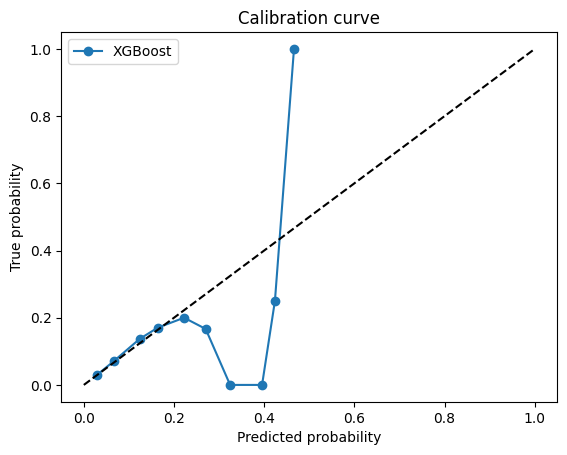

In [168]:
# Plot calibration curve
prob_true, prob_pred = calibration_curve(y_val, y_pred_val, n_bins=20)
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration curve')
plt.legend()
plt.show()

# Calibrate model

## Logistic regression

In [169]:
# Logistic calibration
calibrated_model_logistic = CalibratedClassifierCV(
    estimator=final_model, 
    method='sigmoid',  # Platt scaling: assumes logistic relatipnship between true probabilities and model output
    cv='prefit'  # Use the already fitted model
)


In [170]:
# Fit the calibrated model on the validation data
calibrated_model_logistic.fit(X_val_transformed, y_val)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1.0,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.2, eval_metric=None,
                                               feature_types=None, gamma=0,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=2,
                                               max_leaves=None,
                                               min_child_weight=5, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None, ...))

In [171]:
# Predict calibrated probabilities
y_pred_calibrated_logistic = calibrated_model_logistic.predict_proba(X_val_transformed)[:, 1]

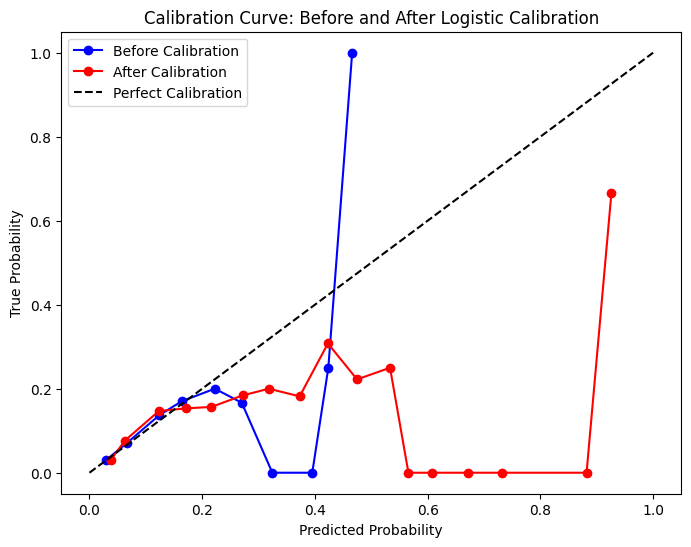

In [172]:
# Plot the calibration curve
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_val, y_pred_calibrated_logistic, n_bins=20)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Before Calibration', color='blue')
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', label='After Calibration', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve: Before and After Logistic Calibration')
plt.legend()
plt.show()

## Isotonic regression

In [173]:
# Use Platt Scaling
calibrated_model_isotonic = CalibratedClassifierCV(
    estimator=final_model, 
    method='isotonic',  # non-parametric, maps probabilities monotonically: higher predicted probability -> higher probability
    cv='prefit'  # Use the already fitted model
)


In [174]:
# Fit the calibrated model on the validation data
calibrated_model_isotonic.fit(X_val_transformed, y_val)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1.0,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.2, eval_metric=None,
                                               feature_types=None, gamma=0,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=2,
                                               max_leaves=None,
                                               min_child_weight=5, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None, ...),
                       method='isotonic')

In [175]:
# Predict calibrated probabilities
y_pred_calibrated_isotonic = calibrated_model_isotonic.predict_proba(X_val_transformed)[:, 1]

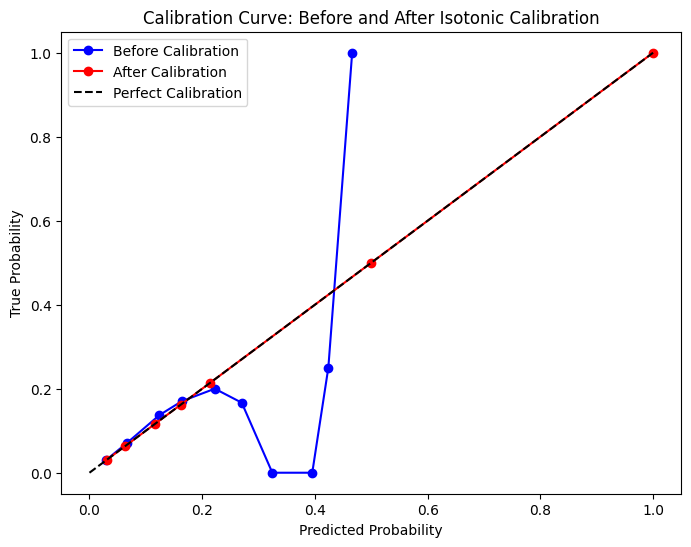

In [176]:
# Plot the calibration curve
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_val, y_pred_calibrated_isotonic, n_bins=20)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Before Calibration', color='blue')
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', label='After Calibration', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve: Before and After Isotonic Calibration')
plt.legend()
plt.show()

In [177]:

brier_isotonic = brier_score_loss(y_val, y_pred_calibrated_isotonic)  # For isotonic calibration)
brier_logistic = brier_score_loss(y_val, y_pred_calibrated_logistic)  # For logistic calibration
print(f"Brier Score (Isotonic): {brier_isotonic:.4f}")
print(f"Brier Score (Logistic): {brier_logistic:.4f}")


Brier Score (Isotonic): 0.0515
Brier Score (Logistic): 0.0521


## Evaluate on the test set

In [178]:
# Transform full training data
X_full_train_transformed = preprocessing_pipeline.fit_transform(df_full_train[numerical_features + categorical_features])
y_full_train = df_full_train['default'].values

# Transform test data
X_test_transformed = preprocessing_pipeline.transform(df_test[numerical_features + categorical_features])
y_test = df_test['default'].values


In [180]:
# Fit the best model on the full training data
final_model.fit(X_full_train_transformed, y_full_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [183]:

# Use Platt Scaling
calibrated_model_isotonic_full = CalibratedClassifierCV(
    estimator=final_model, 
    method='isotonic',  # non-parametric, maps probabilities monotonically: higher predicted probability -> higher probability
    cv='prefit'  # Use the already fitted model
)

# Fit the calibrated model on the full training data
calibrated_model_isotonic_full.fit(X_full_train_transformed, y_full_train)


CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1.0,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.2, eval_metric=None,
                                               feature_types=None, gamma=0,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=2,
                                               max_leaves=None,
                                               min_child_weight=5, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None, ...),
                       method='isotonic')

In [184]:
y_pred_calibrated_full = calibrated_model_isotonic_full.predict_proba(X_test_transformed)[:, 1]


In [185]:
# Final AUC score on test data
auc = roc_auc_score(y_test, y_pred_calibrated_full)
print(f"Test AUC: {auc:.3f}")

# Final PR AUC score on test data,
pr_auc = average_precision_score(y_test, y_pred_calibrated_full)
print(f"Test PR AUC: {pr_auc:.3f}")

Test AUC: 0.689
Test PR AUC: 0.114


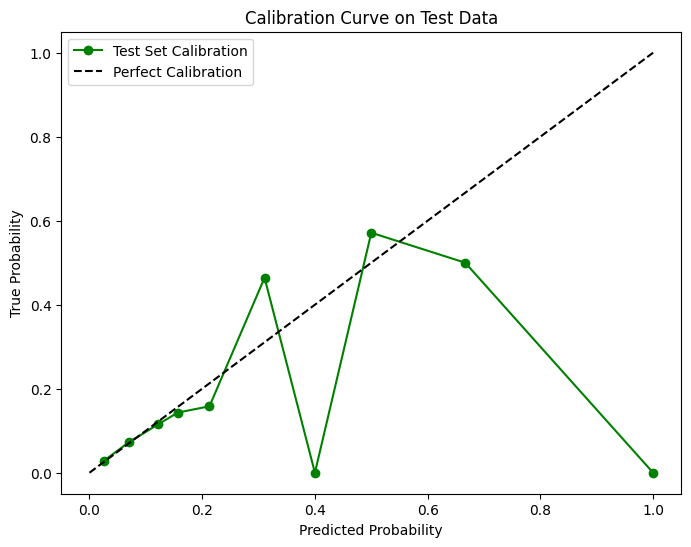

ROC AUC on Test Set: 0.6890
Brier Score on Test Set: 0.0511


In [189]:


# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_calibrated_full, n_bins=20)

# Metrics
roc_auc = roc_auc_score(y_test, y_pred_calibrated_full)
brier_score = brier_score_loss(y_test, y_pred_calibrated_full)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Test Set Calibration', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve on Test Data')
plt.legend()
plt.show()

# Print metrics
print(f"ROC AUC on Test Set: {roc_auc:.4f}")
print(f"Brier Score on Test Set: {brier_score:.4f}")
